1. Camera Calibration
2. Undistort
3. Sobel Gradient
4. Perspective Transform
5. Lane Search

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

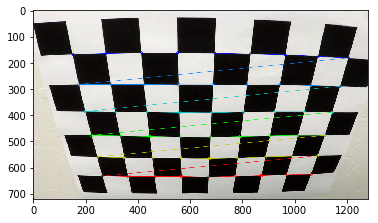

In [4]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) # the z-coordinate is set at zero
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # List of pairs coordinates (x, y on the chessboard)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(calib_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    if idx == 5:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)
        plt.show()
        
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)
        
calibration_pickle = {}
calibration_pickle["mtx"] = mtx
calibration_pickle["dist"] = dist
pickle.dump(calibration_pickle, open("camera_cal/wide_calib_pickle.p", "wb" ))

## Calibration

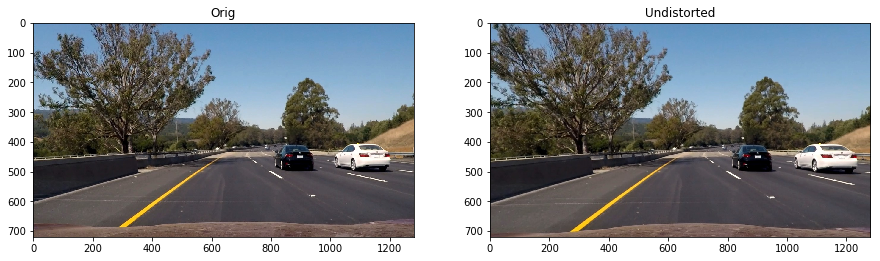

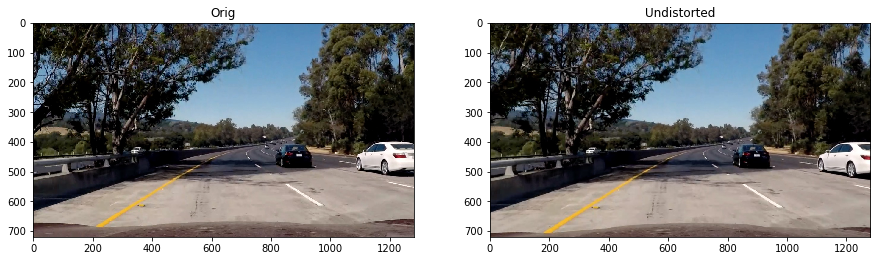

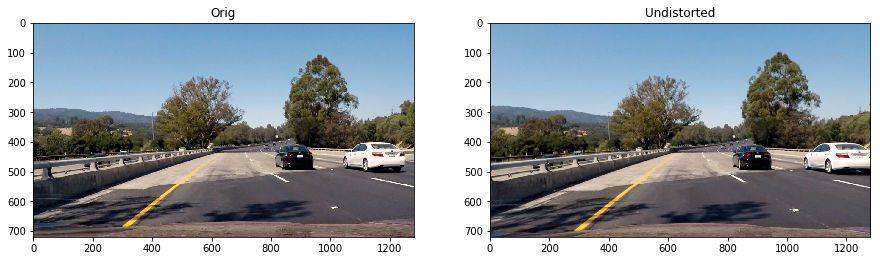

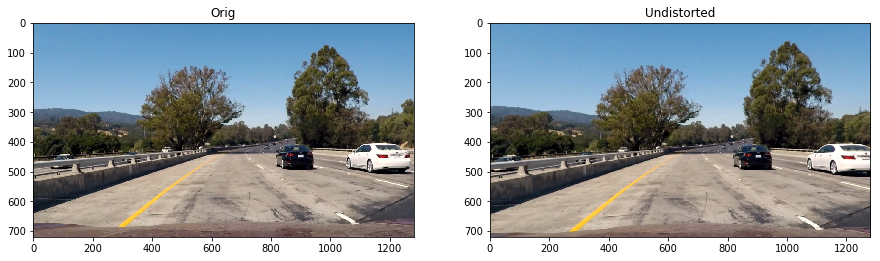

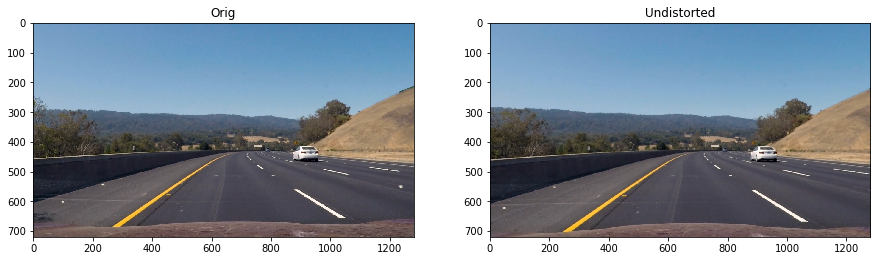

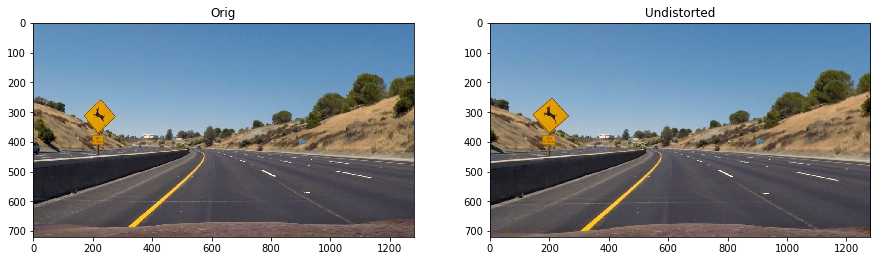

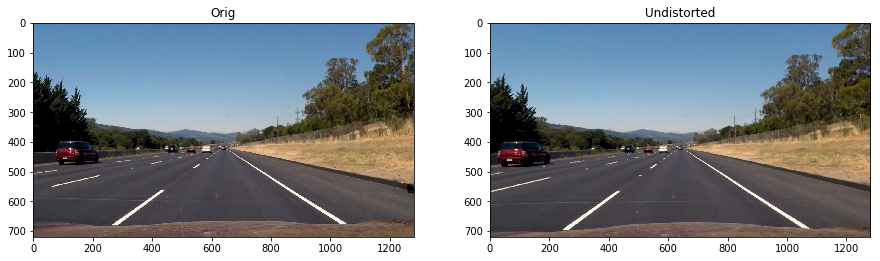

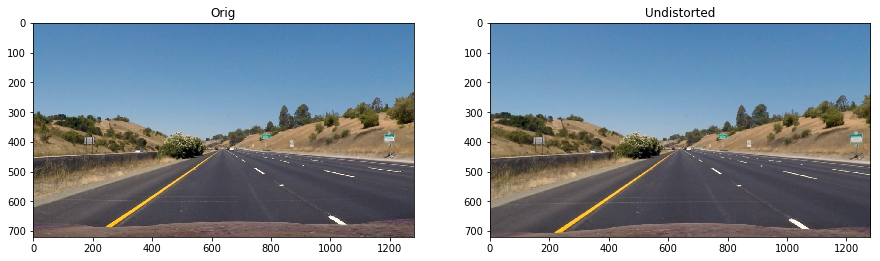

In [5]:
test_images = glob.glob('test_images/*.jpg')
undistort_test_images = []
for fname in test_images:
    test_img = mpimg.imread(fname)
    undistort = cv2.undistort(test_img, mtx, dist, None, mtx)
    undistort_test_images.append(undistort)
    plt.figure(figsize=(15,15))
    plt.subplot(121, title='Orig')
    plt.imshow(test_img)
    plt.subplot(122, title='Undistorted')
    plt.imshow(undistort)

## Thresholding

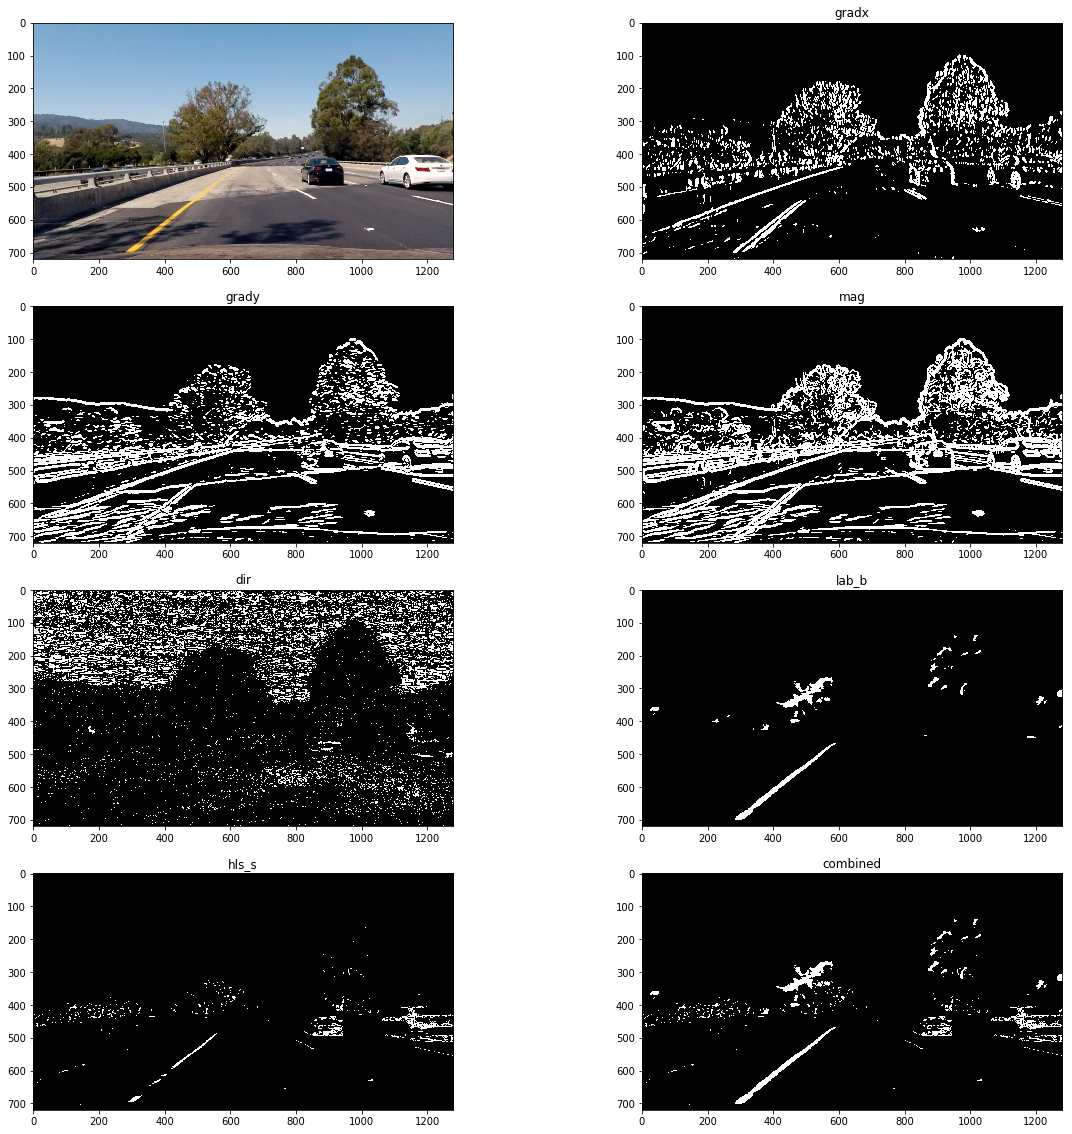

In [6]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    scaled_sobel = np.uint8(255*np.absolute(sobel)/np.max(np.absolute(sobel)))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    scaled_sobel = np.uint8(255*direction/np.max(direction))
    dir_binary = np.zeros_like(scaled_sobel)
    dir_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return dir_binary

def color_threshold(layer, thresh=(0, 255)):
    if np.max(layer) > 175:
        layer = layer*(255/np.max(layer))
    color_binary = np.zeros_like(layer)
    color_binary[(layer >= thresh[0]) & (layer <= thresh[1])] = 1
    return color_binary

def image_thresholding(img, ksize = 25, sobel_thresh=(25, 255), dir_thresh=(0, 0.09), show=False):
    lab_l = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:, :, 0]
    lab_b = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:, :, 2]
    hls_s = (cv2.cvtColor(img, cv2.COLOR_RGB2HLS))[:, :, 2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(lab_l, orient='x', sobel_kernel=ksize, thresh=sobel_thresh)
    grady = abs_sobel_thresh(lab_l, orient='y', sobel_kernel=ksize, thresh=sobel_thresh)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=sobel_thresh)
    dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=dir_thresh)
    lab_b_binary = color_threshold(lab_b, thresh=(190, 255))
    hls_s_binary = color_threshold(hls_s, thresh=(220, 255))
    combined = np.zeros_like(gray)
    combined[(hls_s_binary == 1) | (lab_b_binary == 1)] = 1
    if show:
        plt.figure(figsize=(20, 20))
        plt.subplot(421)
        plt.imshow(img)
        plt.subplot(422, title='gradx')
        plt.imshow(gradx, cmap='gray')
        plt.subplot(423, title='grady')
        plt.imshow(grady, cmap='gray')
        plt.subplot(424, title='mag')
        plt.imshow(mag_binary, cmap='gray')
        plt.subplot(425, title='dir')
        plt.imshow(dir_binary, cmap='gray')
        plt.subplot(426, title='lab_b')
        plt.imshow(lab_b_binary, cmap='gray')
        plt.subplot(427, title='hls_s')
        plt.imshow(hls_s_binary, cmap='gray')
        plt.subplot(428, title='combined')
        plt.imshow(combined, cmap='gray')
    return combined
        
out = image_thresholding(undistort_test_images[2], show=True)

In [88]:
thresholded_test_images = []
for img in undistort_test_images:
    thresholded = image_thresholding(img)
    thresholded_test_images.append(thresholded)

## Perspective Transform

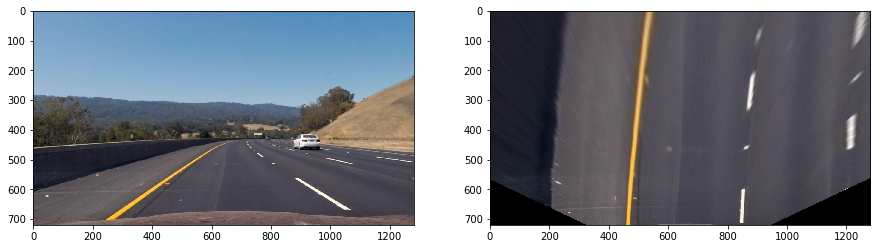

In [108]:
def perspective_transform(undistort, mtx, dist, corners, dst_corners=None):
    y, x = undistort.shape[0], undistort.shape[1]
    src = np.float32(corners)
    # Get the destination coordinates
    if dst_corners:
        dst = np.float32(dst_corners)
    else:
        offset = 0
        dst = np.float32([[450, offset], [x-450, offset], [450, y], [x-450, y]])
    # Get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    transformed = cv2.warpPerspective(undistort, M, (x,y))
    return transformed

# Top left, top right, bottom right, bottom left. [ [], [], [], [] ]. (1280, 720)
corners = [(575,464), (707,464), (258,682), (1049,682)]
dst_img = perspective_transform(undistort_test_images[4], mtx, dist, corners)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(undistort_test_images[4], cmap='gray')
plt.subplot(122)
plt.imshow(dst_img, cmap='gray')

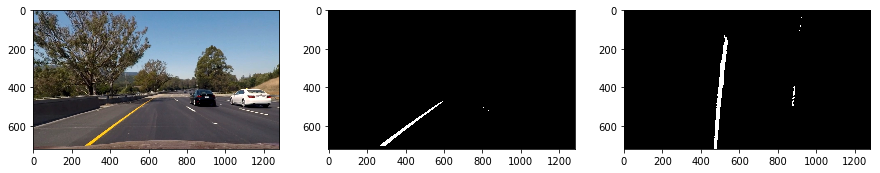

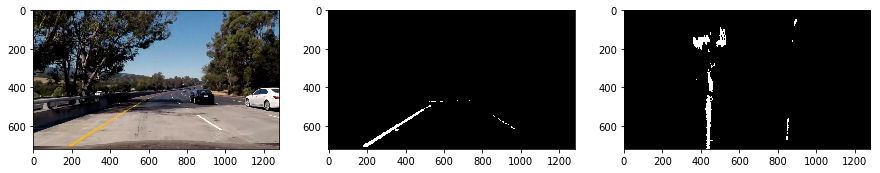

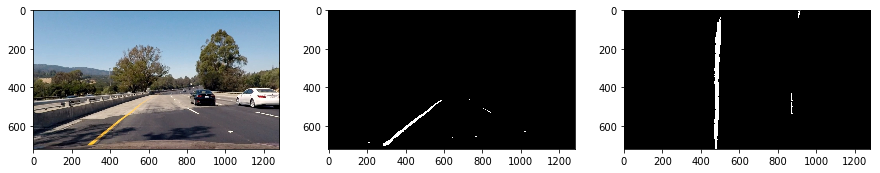

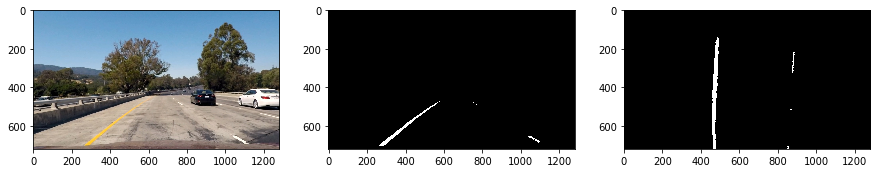

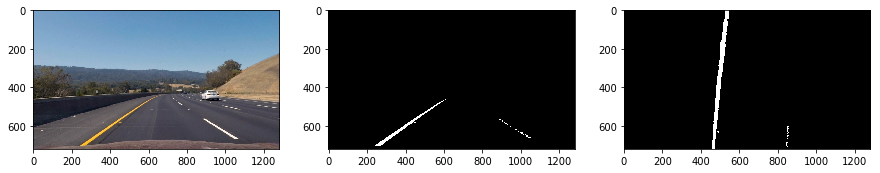

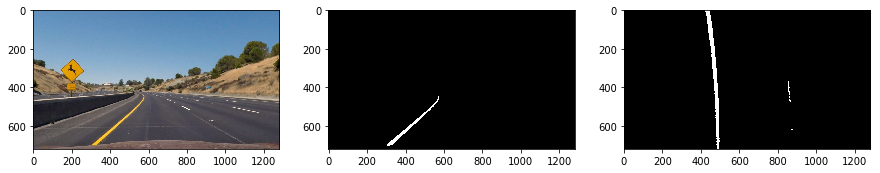

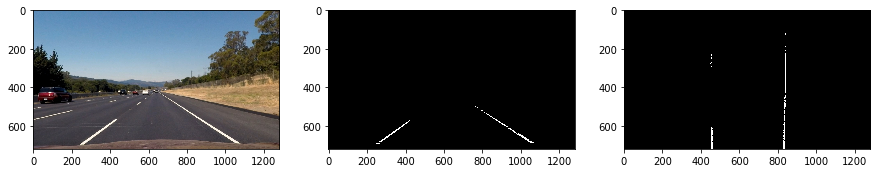

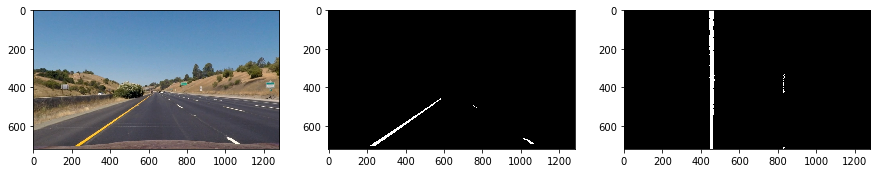

In [109]:
def get_vertices(img, bottom_width = 0.85, top_width = 0.07, height_prop = 0.4):
    """
    Return vertices that define the polygon where the lanes are. 
    Top and bottom edges of trapezoid are expressed as percentage of image width.
    Height of the trapezoid expressed as percentage of image height.
    Measurements are suggested by @georgesung
    """
    imshape = img.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height_prop),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height_prop),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0])]], dtype=np.int32)
    return vertices

def region_of_interest(img, vertices):
    """
    Given a set of polygon vertices, apply an image mask, keep the region of the image defined by the polygon
    The rest of the image is set to black.
    """
    # Define a black mask
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[3]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Return the image only where mask pixels (inside the ROI) are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

lanes_thresholded = []
for idx, img in enumerate(thresholded_test_images):
    masked_img = region_of_interest(img, get_vertices(img))
    dst_img = perspective_transform(masked_img, mtx, dist, corners)
    lanes_thresholded.append(dst_img)
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.imshow(undistort_test_images[idx], cmap='gray')
    plt.subplot(132)
    plt.imshow(masked_img, cmap='gray')
    plt.subplot(133)
    plt.imshow(dst_img, cmap='gray')

## Lanes

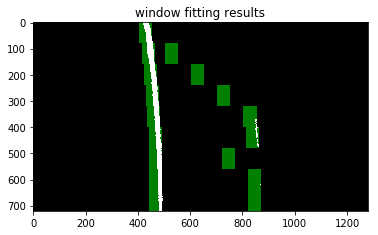

In [113]:
# Read in a thresholded image
warped = lanes_thresholded[5]
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else: 
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [111]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')

...


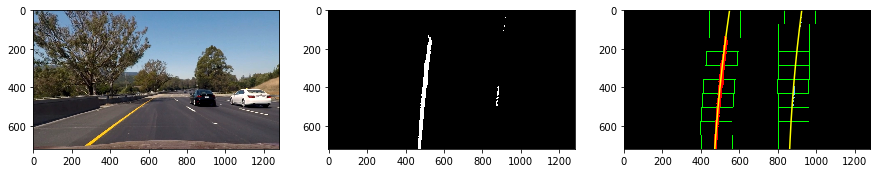

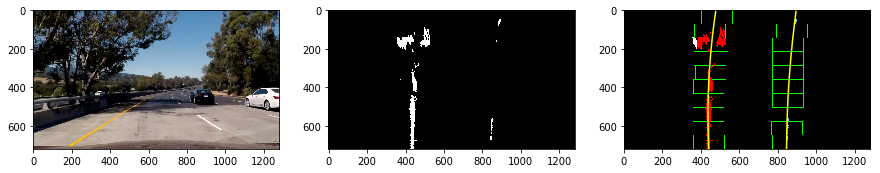

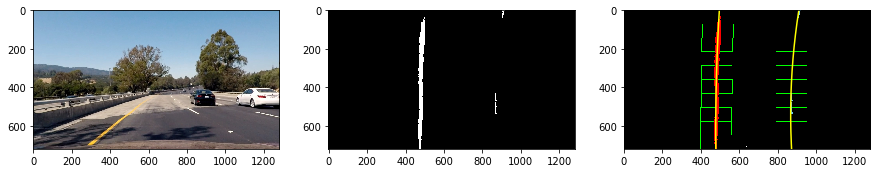

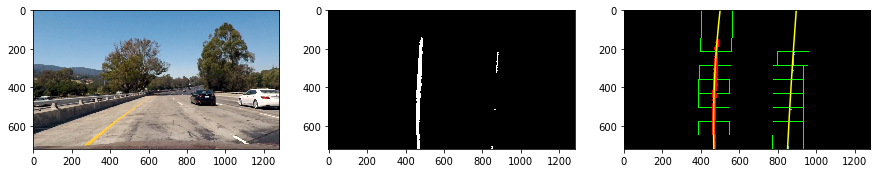

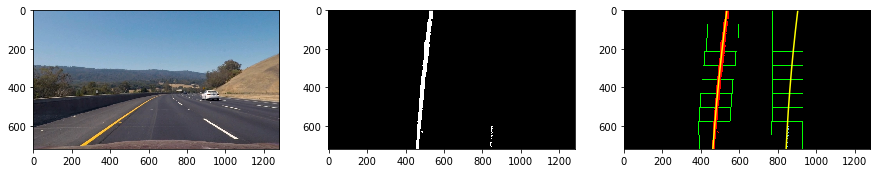

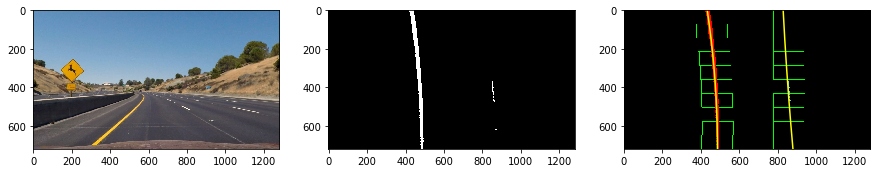

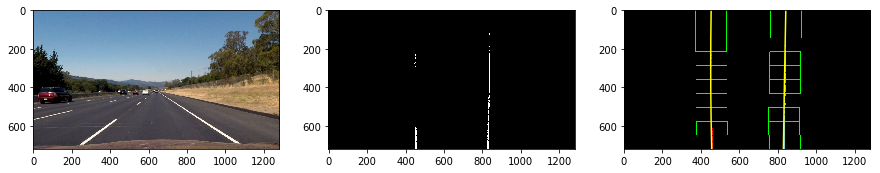

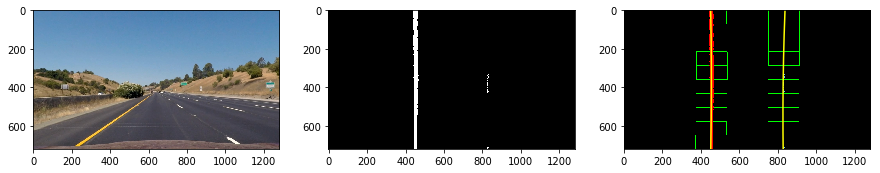

In [112]:
for idx, exampleImg_bin in enumerate(lanes_thresholded):
    exampleImg = undistort_test_images[idx]
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

    y = exampleImg.shape[0]
    left_fit_x_int = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fit_x_int = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    #print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    for rect in rectangles:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(exampleImg)
    plt.subplot(1,3,2)
    plt.imshow(exampleImg_bin, cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)